<a href="https://colab.research.google.com/github/AndresMontesDeOca/TimeSeries/blob/main/TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imortamos Librerias

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

!pip install pmdarima

import warnings
warnings.filterwarnings('ignore')

# Suprimimos Notacion Cientfica
pd.set_option('display.float_format', lambda x: '%.2f' % x)


##Cargamos el Dataset

In [33]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Demanda Energia
id = '1LV2t7HpwYpxSumUywyRE1wZ2xyF1KF5I'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('DemoHoraria_v2.csv')
data = pd.read_csv('DemoHoraria_v2.csv') # Cargamos el Dataset

display(data.head())

,data_hora,Demanda_MW,Vel_viento
0,2015-10-01 02,1032.75,29.90
1,2015-10-01 03,960.61,17.30
2,2015-10-01 04,938.91,8.71
3,2015-10-01 05,943.28,7.25
4,2015-10-01 06,977.78,16.47


## Preprocesamiento

In [34]:
# Verificamos el Dataset

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   data_hora   65535 non-null  object 
 1   Demanda_MW  65535 non-null  float64
 2   Vel_viento  65535 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.5+ MB
None


- 65000 Registros
- No se observan nulos

In [35]:
# Eliminamos la Variable de Velocidad del Viento
data.drop(columns='Vel_viento', inplace=True)

# Convertimos la columna "data_hora" a tipo de datos de fecha y hora
data['data_hora'] = pd.to_datetime(data['data_hora'], format='%Y-%m-%d %H')

# Renombramos el nombre de las variables
data.rename(columns={'Demanda_MW':'Demanda', 'data_hora':'Fecha'}, inplace=True)

# Seteamos la Fecha como Index
data = data.set_index('Fecha')

display(data.head())

,Demanda
Fecha,
2015-10-01 02:00:00,1032.75
2015-10-01 03:00:00,960.61
2015-10-01 04:00:00,938.91
2015-10-01 05:00:00,943.28
2015-10-01 06:00:00,977.78


### Analizamos la Variable de estudio "Demanda"

In [36]:
# Hacemos un Describe
display(data.describe())

,Demanda
count,65535.00
mean,2968922103603471429081759744.00
std,730611400952401882395598389248.00
min,-555555.00
25%,1091.63
50%,1265.12
75%,1432.30
max,186877000000000019090986688839680.00


- Los valores absolutos son muy grandes, posibles errores?
- Hay valores Negativos, tambien posibles errores?

In [37]:
# Vemos en que fechas tenemos los errores. Cotas establecidas por el negocio [600, 2500]
display(data.query('Demanda > 2500 or Demanda < 600'))

,Demanda
Fecha,
2017-08-26 06:00:00,514.45
2017-08-26 07:00:00,388.61
2017-10-19 10:00:00,7691310000000000899886144815104.00
2017-10-19 11:00:00,186877000000000019090986688839680.00
2017-11-16 03:00:00,-555555.00
2017-11-20 03:00:00,-555555.00
2017-11-25 03:00:00,-555555.00
2018-03-20 10:00:00,2265329999999999934464.00
2018-03-20 11:00:00,43041200000000000524288.00


In [38]:
# Calculamos la Mediana general
median_demand = data['Demanda'][data['Demanda'].between(600, 2500)].median()
print('Mediana:', median_demand)

# Reemplazar valores extremos y negativos por la mediana calculada
data['Demanda'] = data['Demanda'].apply(lambda x: median_demand if x > 2500 or x < 600 else x)

# Hacemos otro Describe para verificar la correccion de los errores
display(data.describe())

Mediana: 1265.12051


,Demanda
count,65535.00
mean,1275.44
std,240.56
min,676.16
25%,1091.71
50%,1265.12
75%,1432.20
max,2237.63


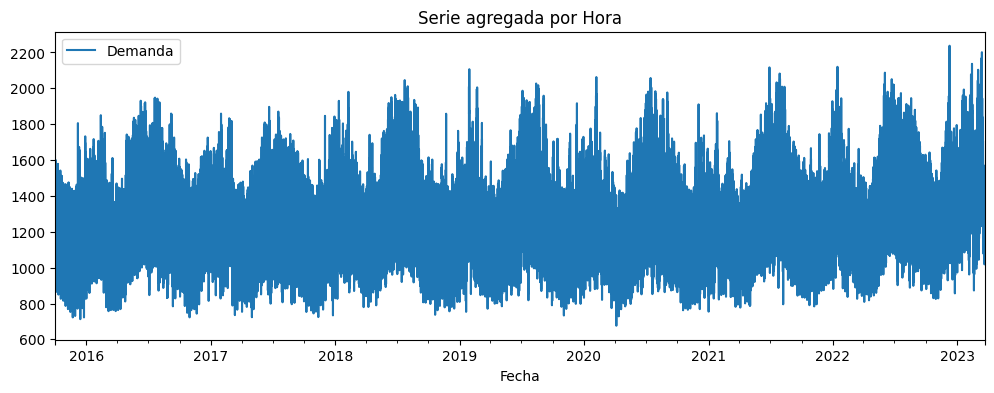

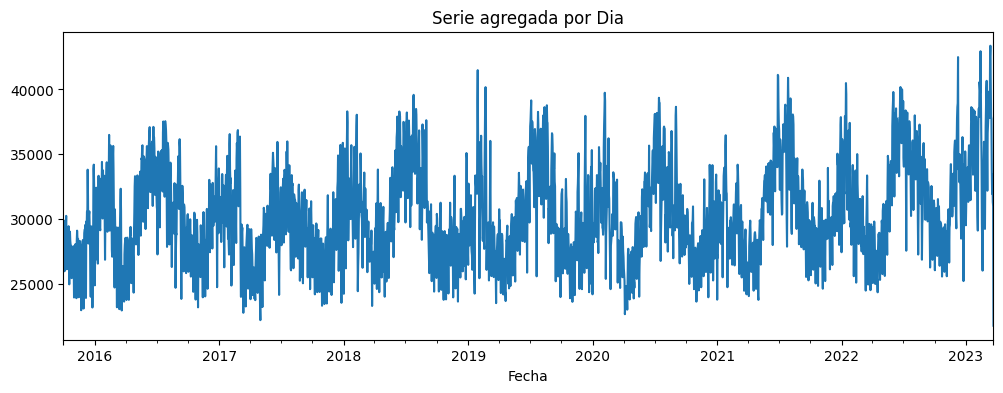

In [39]:
# Ploteamos para ver como quedaria la serie corregida
data.plot(title='Serie agregada por Hora', figsize=(12, 4))
plt.show()

# El corte por hora es muy atomizado, agregamos por dia
data_daily = data['Demanda'].resample('D').sum()
data_daily.plot(title='Serie agregada por Dia', figsize=(12, 4))
plt.show()

# Seguimos con la variable data
data = data_daily.to_frame() # Lo paso a Pandas DataFrame, sino me lo transforma a Pandas Serie

## Analisis de Estacionariedad

In [40]:
from statsmodels.tsa.stattools import adfuller

# Realizo el test analitico de Dickey-Fuller y me traigo solo el p-value
p_value = adfuller(data['Demanda'])[1]


print('P-Value del test Analitico:', p_value)

P-Value del test Analitico: 7.991704282937024e-06


- Se rechaza la H0 de No-Estacionariedad, podemos confirmar que la serie es Estacionaria

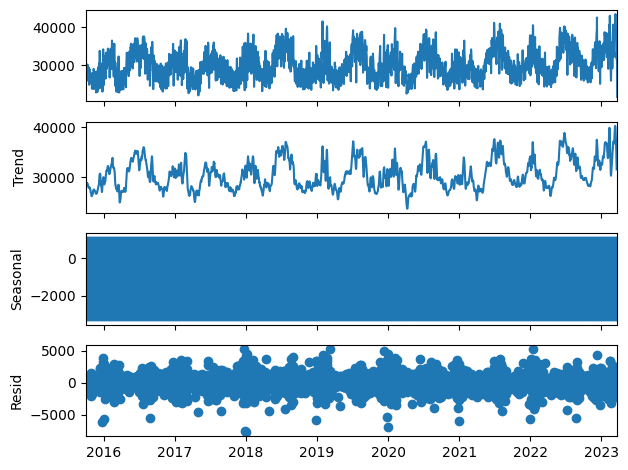

In [41]:
# Realizamos otros test graficos
# Hay que revisar el tema del periodo, esta bien usar 30/31? Aditivo o Multiplicativo??
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(data).plot() # Parametro figsize no funciona con el seasonal_decompose
plt.show()

- Sin embargo, en el analisis de las graficas, parece ser que la serie tiene estacionalidad, por ende podria llegar a ser no-estacionaria
- Nos conviene diferenciar la serie

## Diferenciacion Lag1 vs Lag7

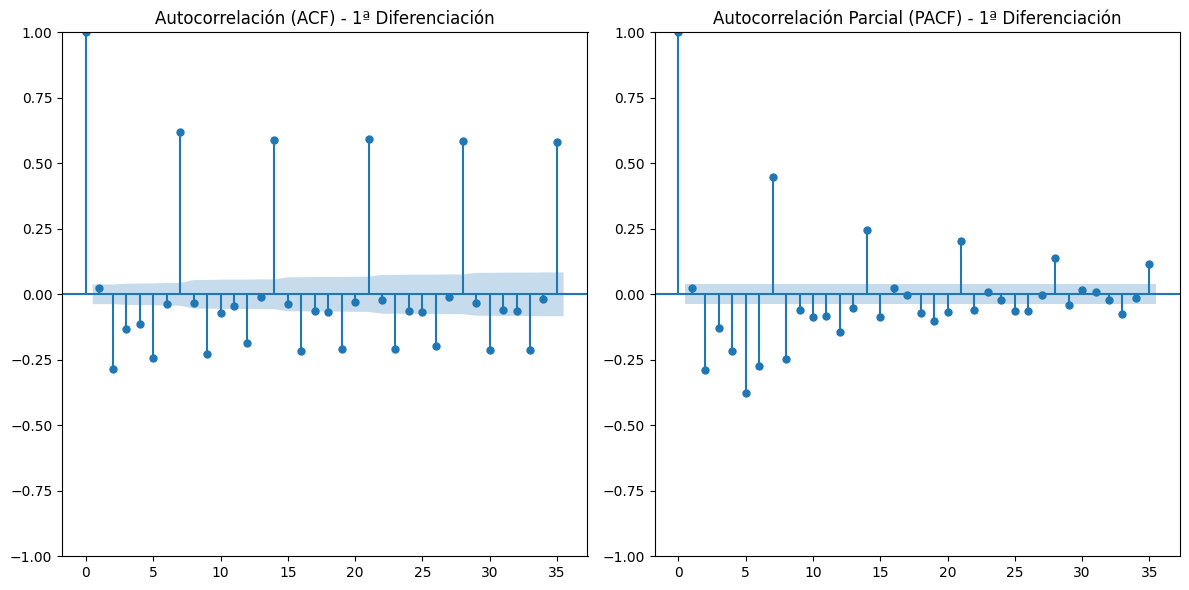

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Aplicando una primera diferenciación
data_diff1 = data.diff().dropna()

# Configurando el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Creando el gráfico ACF después de la primera diferenciación
plt.subplot(121)
plot_acf(data_diff1, ax=plt.gca(), title='Autocorrelación (ACF) - 1ª Diferenciación')

# Creando el gráfico PACF después de la primera diferenciación
plt.subplot(122)
plot_pacf(data_diff1, ax=plt.gca(), title='Autocorrelación Parcial (PACF) - 1ª Diferenciación')

# Ajustando el layout
plt.tight_layout()
plt.show()


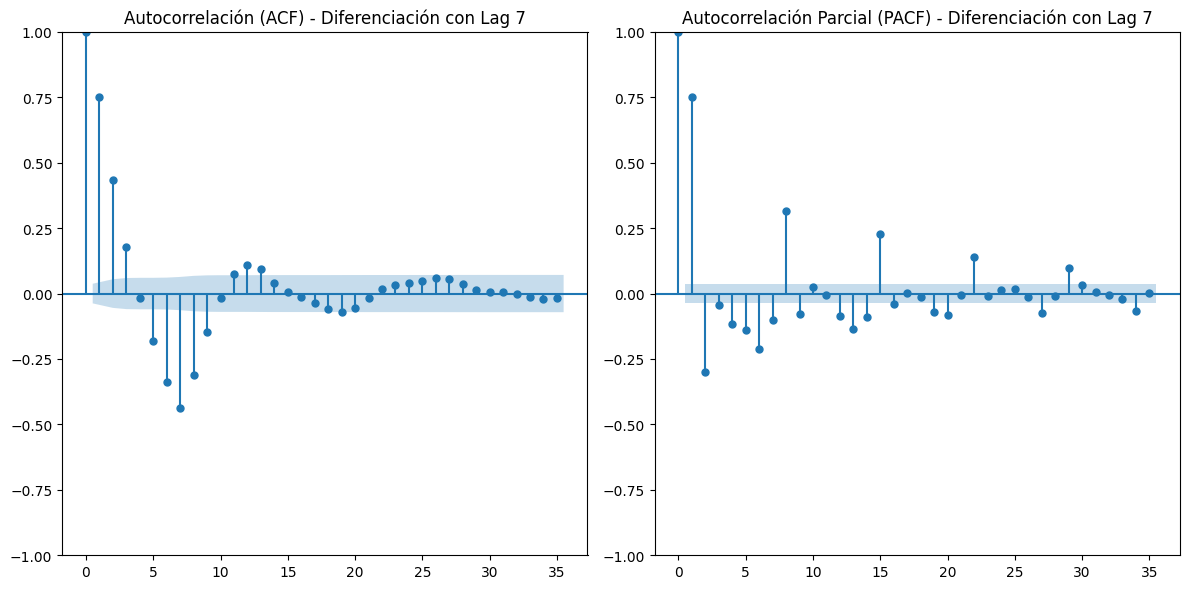

In [43]:
# Aplicando una diferenciación con un lag de 7
data_diff7 = data.diff(7).dropna()

# Configurando el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Creando el gráfico ACF después de la diferenciación con un lag de 7
plt.subplot(121)
plot_acf(data_diff7, ax=plt.gca(), title='Autocorrelación (ACF) - Diferenciación con Lag 7')

# Creando el gráfico PACF después de la diferenciación con un lag de 7
plt.subplot(122)
plot_pacf(data_diff7, ax=plt.gca(), title='Autocorrelación Parcial (PACF) - Diferenciación con Lag 7')

# Ajustando el layout
plt.tight_layout()
plt.show()

- La diferenciacion estacional semanal (lag=7) parece ser la mas indicada

In [44]:
# Confirmacion analitca de Estacionariedad de la serie diferenciada con lag=7

from statsmodels.tsa.stattools import adfuller

# Realizando la prueba de Dickey-Fuller aumentada
resultado_adf = adfuller(data_diff7)

# Mostrando los resultados
# print('Estadístico ADF:', resultado_adf[0])
print('p-valor:', resultado_adf[1])
# print('Valores Críticos:')
# for clave, valor in resultado_adf[4].items():
#     print(f'   {clave}: {valor}')

p-valor: 8.709479434696865e-16


- Lo confirmamos con el p-value tan chico, rechazando la H0 de no-estacionariedad

## Modelo ARMA(p, q)
- Ya hemos diferenciado la serie con un d=7 en el paso anterior
- De la Funcion PACF, decidimos probar con p=1
- De la Funcion ACF, probamos con q=1 y q=7

In [45]:
# Dividiendo los datos en conjuntos de entrenamiento y prueba
train_size = int(len(data_diff7) * 0.8)
train, test = data_diff7[0:train_size], data_diff7[train_size:len(data_diff7)]

# Imprimiendo el tamaño de los conjuntos
print('Tamaño del conjunto de entrenamiento:', len(train))
print('Tamaño del conjunto de prueba:', len(test))

Tamaño del conjunto de entrenamiento: 2179
Tamaño del conjunto de prueba: 545


In [46]:
from statsmodels.tsa.arima.model import ARIMA

# Ajustando el modelo ARMA(1, 1) en el conjunto de entrenamiento
modelo_arma_11_train = ARIMA(train['Demanda'], order=(1, 0, 1))
resultados_arma_11_train = modelo_arma_11_train.fit()

# Ajustando el modelo ARMA(1, 7) en el conjunto de entrenamiento
modelo_arma_17_train = ARIMA(train['Demanda'], order=(1, 0, 7))
resultados_arma_17_train = modelo_arma_17_train.fit()

# Imprimiendo los resúmenes de los modelos
print('Resumen para ARMA(1, 1):')
print(resultados_arma_11_train.summary())
print('\nResumen para ARMA(1, 7):')
print(resultados_arma_17_train.summary())

Resumen para ARMA(1, 1):
                               SARIMAX Results                                
Dep. Variable:                Demanda   No. Observations:                 2179
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -19421.333
Date:                Tue, 24 Oct 2023   AIC                          38850.666
Time:                        22:58:24   BIC                          38873.413
Sample:                    10-08-2015   HQIC                         38858.982
                         - 09-24-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9395    137.088      0.029      0.977    -264.748     272.627
ar.L1          0.6140      0.019     33.056      0.000       0.578       0.650
ma.L1          0.3585      

- Se ve como el ARMA(1, 7), o el ARIMA(1, 0, 7) de la serie diferenciada, nos genera un AIC menor, teniendo todos los coeficientes para cada lag significativos

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Realizando predicciones en el conjunto de prueba
predicciones_arma_11 = resultados_arma_11_train.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
predicciones_arma_17 = resultados_arma_17_train.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Calculando MAE y RMSE para ARMA(1, 1)
mae_arma_11 = mean_absolute_error(test['Demanda'], predicciones_arma_11)
rmse_arma_11 = np.sqrt(mean_squared_error(test['Demanda'], predicciones_arma_11))

# Calculando MAE y RMSE para ARMA(1, 7)
mae_arma_17 = mean_absolute_error(test['Demanda'], predicciones_arma_17)
rmse_arma_17 = np.sqrt(mean_squared_error(test['Demanda'], predicciones_arma_17))

# Imprimiendo las métricas
print('Métricas para ARMA(1, 1):')
print('MAE:', mae_arma_11)
print('RMSE:', rmse_arma_11)
print('\nMétricas para ARMA(1, 7):')
print('MAE:', mae_arma_17)
print('RMSE:', rmse_arma_17)

Métricas para ARMA(1, 1):
MAE: 2227.0010865568916
RMSE: 3186.7942255577373

Métricas para ARMA(1, 7):
MAE: 2232.349162348981
RMSE: 3189.6020995695694


- Cuando probamos el modelo contra los datos de Test, vemos que el MAE es menor en el ARMA(1, 1), pero por muy poco

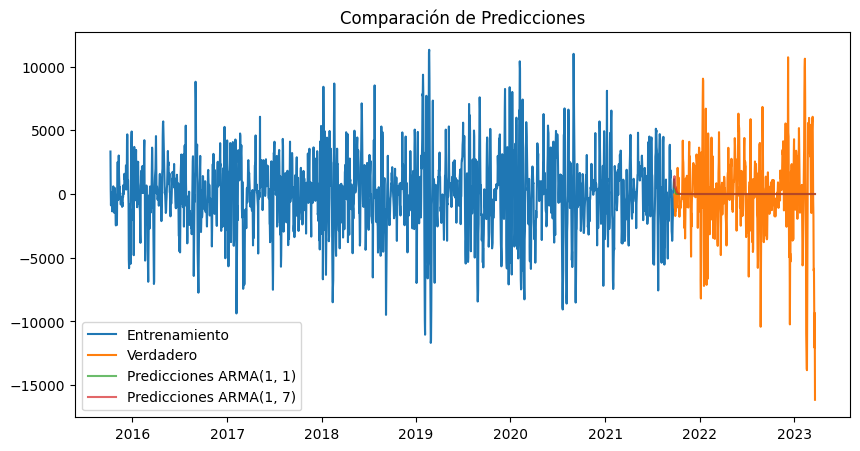

In [48]:
# Graficando las predicciones contra los valores reales
plt.figure(figsize=(10, 5))
plt.plot(train['Demanda'], label='Entrenamiento')
plt.plot(test['Demanda'], label='Verdadero')
plt.plot(predicciones_arma_11, label='Predicciones ARMA(1, 1)', alpha=0.7)
plt.plot(predicciones_arma_17, label='Predicciones ARMA(1, 7)', alpha=0.7)
plt.legend()
plt.title('Comparación de Predicciones')
plt.show()

- Como la Series es Estacionaria y Centrada, las predicciones tienden a Media (osea 0)
- Recordemos que las Series Estacionarias se comportan como Ruido Blanco